In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.colors as mcolors
import scipy
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

In [2]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'] # An array of colors for matplotlib to access

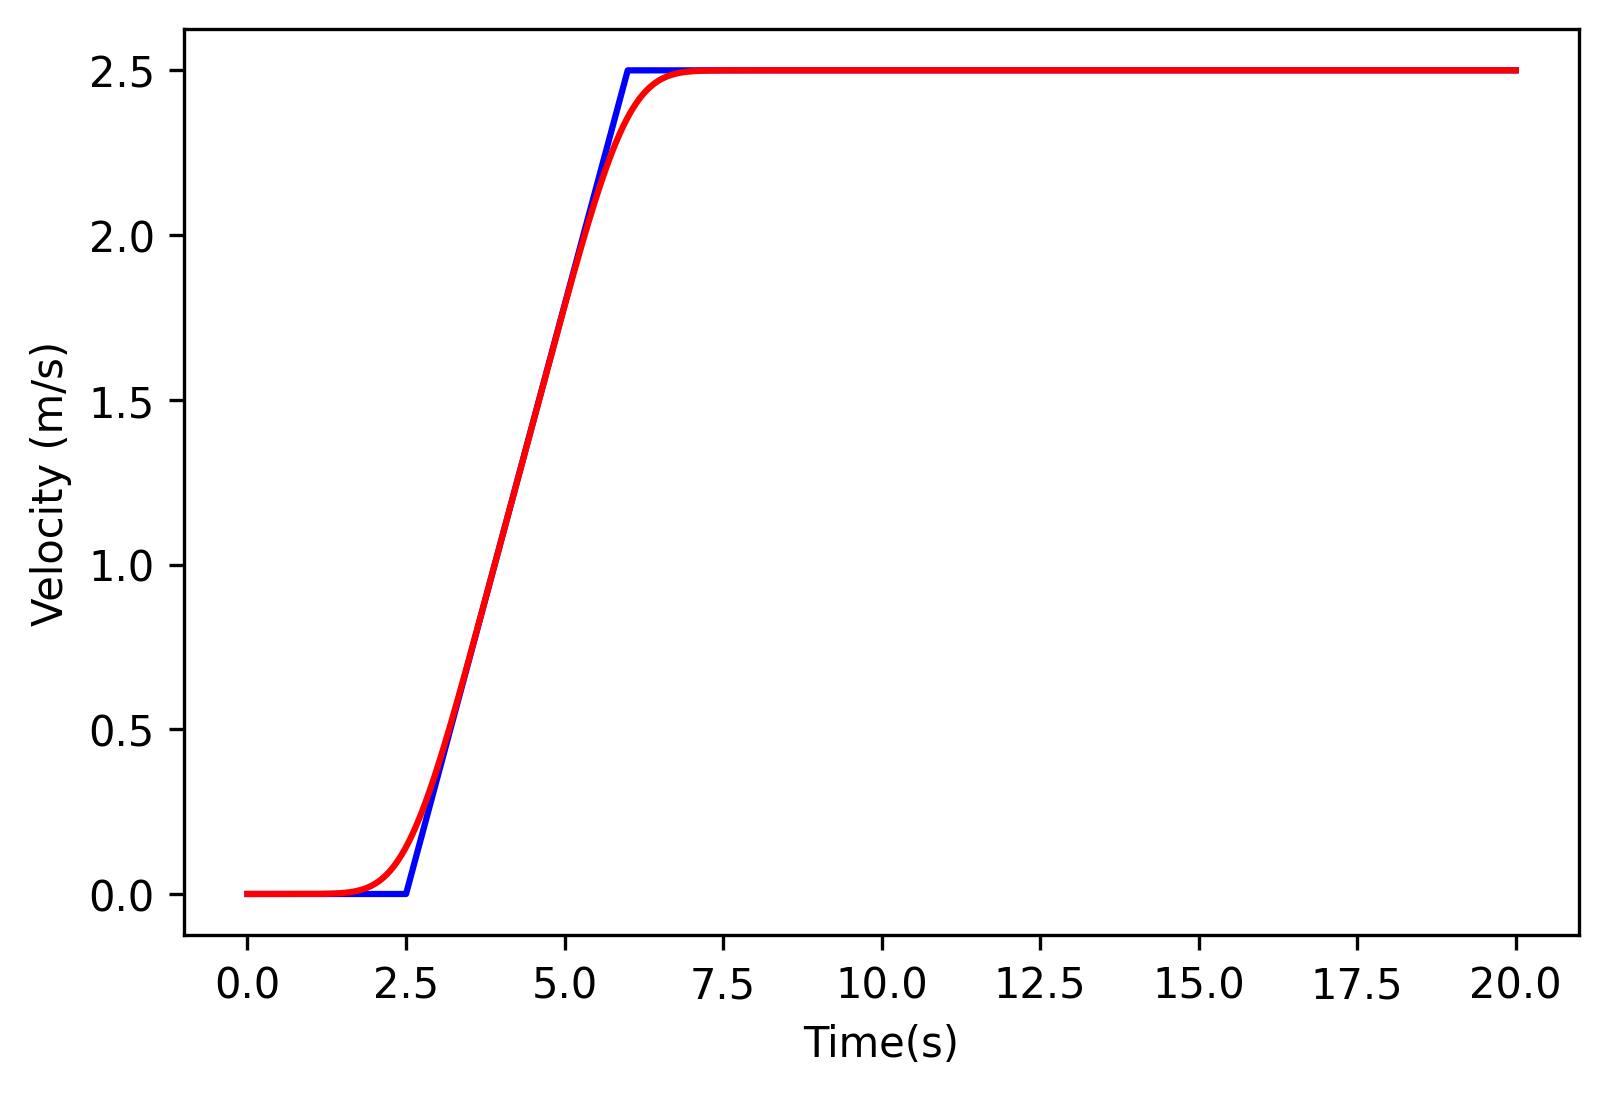

In [3]:
# % VELOCITY PROFILE GENERATION
velocity_final = 2.5                                                      # Final ball-bot velocity (m/s)
a_start = 2.5                                                          # Start of acceleration (s)

t_final = 20                                                           # Duration of the simulation (s)
t_constant = 6 # Ramp lasts from 2.5 s to t_constant                   # Time to reach constant final velocity (s)
dt = 1/200                                                             # Simulation timestep
t_length = int(t_final/dt)                                             # Length of time vector
t = np.linspace(0, t_final, t_length)                                  # Time vector (s)
        
t_ramp_start = int(a_start / dt)
t_ramp_end = round(t_length*(t_constant/t_final))
ramp = np.linspace(0,velocity_final, (t_ramp_end - t_ramp_start) ) 
velocity = np.concatenate((np.zeros(t_ramp_start), ramp, velocity_final*np.ones(t_length - t_ramp_end)))                      # Velocity vector (m/s)
smoothed_velocity = gaussian_filter1d(velocity,100)  #Smoothing velocity with a sigma of 100

plt.figure(dpi=300)
plt.plot(t,velocity, colors[0])
plt.xlabel('Time(s)')
plt.ylabel('Velocity (m/s)')
plt.plot(t,smoothed_velocity,colors[2])
plt.show()


Text(0, 0.5, 'Acceleration (m/s^2)')

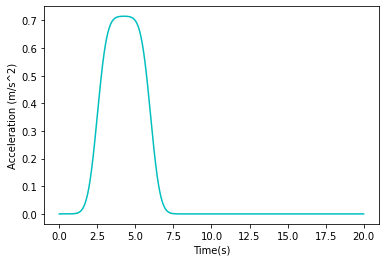

In [4]:
linear_acceleration = np.gradient(smoothed_velocity,dt)
plt.plot(t,linear_acceleration,colors[3])
plt.xlabel('Time(s)')
plt.ylabel('Acceleration (m/s^2)')

Text(0.5, 1.0, 'Lean Angle vs Time')

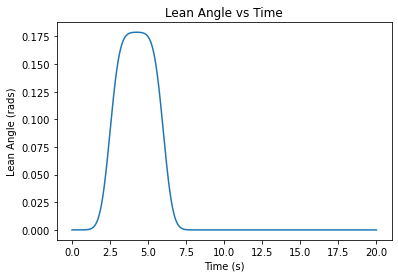

In [13]:
# Plotting Chassis Lean Angle
# % LEAN ANGLE - Some contraints on this variable to make the simulation realistic.  

# Scaling factor for calcuation of lean angle
theta_scale = .25
# Body lean angle (rad)
theta = theta_scale * linear_acceleration
theta_dot = np.gradient(theta,dt)
theta_ddot = np.gradient(theta_dot,dt)

plt.plot(t, theta)
plt.xlabel('Time (s)')
plt.ylabel('Lean Angle (rads)')
plt.title('Lean Angle vs Time')


In [6]:
RHO_STEEL = 7750
RHO_VECTR = 14
RHO_AL = 2700

## approximating telescoping rods as hollow cylinders
s_bar = 4*0.03
l_bar = 1.23
mass_bar = 0.002 * s_bar * l_bar * RHO_STEEL
radius_bar = s_bar / (2 * np.pi)
I_bar = mass_bar * radius_bar**2

## approximating center 'cylinder' as a rectangle (it is actually mostly rectangular)
h_cyl = .1
b_cyl = .15
h_cyl_in = .14
b_cyl_in = .8
l_cyl = 1.23
mass_cyl = l_cyl*(h_cyl * b_cyl - h_cyl_in * b_cyl_in) * RHO_VECTR
I_cyl = 1/12 * mass_cyl*((h_cyl**2 + b_cyl**2) - (h_cyl_in**2 + b_cyl_in**2))

## approximating wheel hub as cylinder closed at one face
radius_hub = .2
mass_hub_base = np.pi * .01 * radius_hub**2 * RHO_STEEL
mass_hub_wall = 2 * np.pi * radius_hub * .01 * RHO_STEEL * .1
I_hub = mass_hub_base / 2 * radius_hub**2 + mass_hub_wall * radius_hub**2

## approximating wheel base as cylinder closed at one base
radius_plate = .25
mass_plate_base = np.pi * .002* radius_plate**2 * RHO_AL
mass_plate_wall = 2 * np.pi * radius_plate * .005 * RHO_AL *.11
I_plate = mass_plate_base / 2 * radius_plate**2 + mass_plate_wall * radius_plate**2

## approximating payload as thin rod about axis
mass_payload = 0
l_payload = 0
I_payload = 1/3 * mass_payload * l_payload**2

## approximating the wheels as a disk
radius_wheel = .75
mass_wheel = .002 * 4.935 * RHO_VECTR #number is calculated SA of torus
I_wheel = 1/2 * mass_wheel * radius_wheel**2

I_wheel = 2 * I_hub + 2 * I_plate + 2*I_wheel
I_telescope = I_cyl + mass_cyl * .06**2 + 2 * (mass_bar *(.06**2 + .13**2)) + I_payload + mass_payload*.11**2
M_telescope = mass_payload + mass_cyl + 2 * mass_bar
M_w = 2 * (mass_hub_base + mass_hub_wall + mass_wheel + mass_plate_base + mass_plate_wall)
print("I_wheel: ", I_wheel, 
      "\nI_telescope: ", I_telescope,
      "\nMw:", M_w,
      "\nM_telescope", M_telescope)


I_wheel:  1.604245755333366 
I_telescope:  0.17507576050000004 
Mw: 46.017949036267396 
M_telescope 2.90526


In [7]:
# System Constants
#Materials

safety_factor = 2.5

rho_vectran = 14
rho_steel = 7750
rho_aluminum = 2700

wheel_radius = .75 #Meters
wheel_mass = M_w
wheel_moment = I_wheel

telescope_mass = M_telescope
telescope_moment = I_telescope

total_mass = wheel_mass + telescope_mass
total_mass = total_mass*safety_factor #safety factor for mass calculations
print(total_mass)

122.30802259066849


Text(0, 0.5, 'Angular Acceleration rad/s^2')

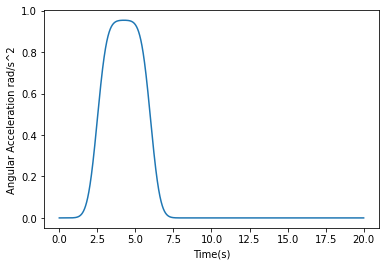

In [8]:
# Converting to angular
angular_velocity = velocity / wheel_radius
angular_acceleration = linear_acceleration / wheel_radius
plt.plot(t,angular_acceleration)
plt.xlabel('Time(s)')
plt.ylabel('Angular Acceleration rad/s^2')

In [16]:
# CONTACT FORCE
contact_force = total_mass * ( scipy.constants.g * np.sin(theta) ) - telescope_moment * theta_ddot

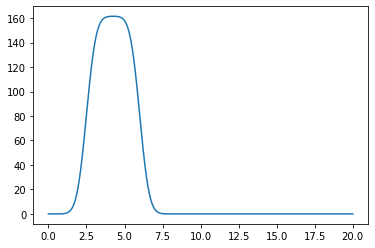

In [18]:
# Wheel Torque Requirement
# T_x = I_w * psi_ddot + F_w_2 * r_w;                                     % Total wheel torque (Nm)

wheel_torque = (wheel_moment * angular_acceleration) + (contact_force * wheel_radius)
plt.plot(t,torque)

Text(0, 0.5, 'Angular Velocity (rad/s)')

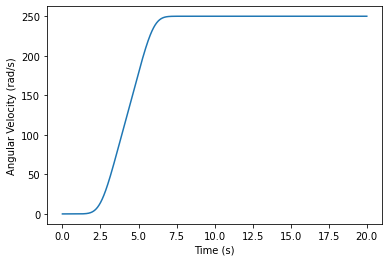

In [22]:
# Transmission Conversion
# Transmission Parameters
ratio = 100
efficiency = .80

motor_velocity = smoothed_velocity * ratio
motor_torque = torque / ( efficiency * ratio)

plt.plot(t,motor_velocity)
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')

Text(0, 0.5, 'Torque (Nm)')

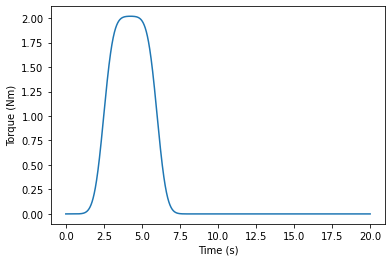

In [23]:
plt.plot(t,motor_torque)
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')